In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
import scipy.stats as stats
import os 
import h5py
import sys
%matplotlib inline 

In [2]:
model_name = "SameScale.h5py"

In [3]:
# Throw away lepton mass 
# os.chdir('./../../../../../data/hongtao')
be = h5py.File('./../../../../../data/hongtao/variables_tt_re.h5','r')
bmu = h5py.File('./../../../../../data/hongtao/variables_tt_rmu.h5','r')
be1 = h5py.File('./../../../../../data/hongtao/variables_tt_re1.h5','r')
print(be.keys())
print('')
print(be1.keys())
dataset = be1

<KeysViewHDF5 ['j1_eta', 'j1_isbtag', 'j1_m', 'j1_phi', 'j1_pt', 'j2_eta', 'j2_isbtag', 'j2_m', 'j2_phi', 'j2_pt', 'j3_eta', 'j3_isbtag', 'j3_m', 'j3_phi', 'j3_pt', 'j4_eta', 'j4_isbtag', 'j4_m', 'j4_phi', 'j4_pt', 'j5_eta', 'j5_isbtag', 'j5_m', 'j5_phi', 'j5_pt', 'j6_eta', 'j6_isbtag', 'j6_m', 'j6_phi', 'j6_pt', 'j7_eta', 'j7_isbtag', 'j7_m', 'j7_phi', 'j7_pt', 'j8_eta', 'j8_isbtag', 'j8_m', 'j8_phi', 'j8_pt', 'lep_eta', 'lep_m', 'lep_phi', 'lep_pt', 'met_met', 'met_phi', 'mttReco', 'mttTrue']>

<KeysViewHDF5 ['bh_eta', 'bh_phi', 'bh_pt', 'bl_eta', 'bl_phi', 'bl_pt', 'j1_DL1r', 'j1_eta', 'j1_isbtag', 'j1_m', 'j1_phi', 'j1_pt', 'j2_DL1r', 'j2_eta', 'j2_isbtag', 'j2_m', 'j2_phi', 'j2_pt', 'j3_DL1r', 'j3_eta', 'j3_isbtag', 'j3_m', 'j3_phi', 'j3_pt', 'j4_DL1r', 'j4_eta', 'j4_isbtag', 'j4_m', 'j4_phi', 'j4_pt', 'j5_DL1r', 'j5_eta', 'j5_isbtag', 'j5_m', 'j5_phi', 'j5_pt', 'j6_DL1r', 'j6_eta', 'j6_isbtag', 'j6_m', 'j6_phi', 'j6_pt', 'j7_DL1r', 'j7_eta', 'j7_isbtag', 'j7_m', 'j7_phi', 'j7_pt'

In [4]:
input_keys = ['j1_pt', 'j1_eta', 'j1_phi', 'j1_m', 'j1_DL1r', 'j2_pt', 'j2_eta', 'j2_phi', 'j2_m', 'j2_DL1r', 'j3_pt', 'j3_eta', 'j3_phi', 'j3_m', 'j3_DL1r', 'j4_pt', 'j4_eta', 'j4_phi', 'j4_m', 'j4_DL1r', 'j5_pt', 'j5_eta', 'j5_phi', 'j5_m', 'j5_DL1r', 'j6_pt', 'j6_eta', 'j6_phi', 'j6_m', 'j6_DL1r', 'j7_pt', 'j7_eta', 'j7_phi','j7_m', 'j7_DL1r', 'j8_pt', 'j8_eta', 'j8_phi','j8_m', 'j8_DL1r', 'lep_pt', 'lep_eta', 'lep_phi', 'met_met', 'met_phi'] 
output_keys = ['th_pt', 'th_eta','th_phi', 'tl_pt', 'tl_eta', 'tl_phi']
phi_keys = ['j1_phi', 'j2_phi', 'j3_phi','j4_phi','j5_phi','j6_phi','j7_phi','j7_phi', 'j8_phi', 'lep_phi', 'met_phi', 'th_phi', 'tl_phi']
eta_keys = ['j1_eta', 'j2_eta', 'j3_eta', 'j4_eta', 'j5_eta', 'j5_phi', 'j6_eta', 'j7_eta', 'j8_eta', 'lep_eta', 'th_eta', 'tl_eta']
pt_keys = ['j1_pt', 'j2_pt','j3_pt','j4_pt','j5_pt','j6_pt','j7_pt','j8_pt','lep_pt','th_pt', 'tl_pt']
m_keys = ['j1_m','j2_m', 'j3_m', 'j4_m', 'j5_m', 'j6_m','j7_m','j8_m']
DL1r_keys = ['j1_DL1r','j2_DL1r','j3_DL1r','j4_DL1r','j5_DL1r','j6_DL1r','j7_DL1r','j8_DL1r',]

output_length = len(output_keys)
input_length = len(input_keys)

In [5]:
# plt.figure(figsize=(8,8*output_length))
# for i in range(0, output_length):
#     plt.subplot(output_length, 1, i+1)
#     plt.hist(dataset.get(output_keys[i]), 20, histtype='step')
#     plt.xlabel(output_keys[i])
#     plt.ylabel('Frequency')

In [6]:
def phi_transform(arr, max0, mean):
    arr = (arr-mean)
    arr = arr/max0/1.01/2+0.5
    z = stats.norm.ppf(arr)/2.5
    return z 

def invphi_transform(z, max0, mean):
    arr = stats.norm.cdf(2.5*z)
    arr = (arr-0.5)*max0*1.01*2+mean
    return arr 

# def phi_transform1(arr, max0, mean):
#     arr = (arr-mean)
#     arr = arr/max0/1.01
#     return (z, max0, mean)

# def invphi_transform1(z, max0, mean):
#     arr = arr*np.pi*1.01+mean
#     return arr

def pt_transform(arr, max0, mean):
    return arr/max0

def invpt_transform(z, max0, mean):
    return z*max0 

def meanmax_transform(arr, max0, mean):
    arr = arr-mean
    z = arr/max0
    return z

def invmeanmax_transform(z, max0, mean):
    return z*max0+mean

def get_maxmean_dict(): 
    to_get = [pt_keys, eta_keys, m_keys, DL1r_keys]
    keys = ['pt', 'eta', 'm','DL1r']
    maxmean= {} 
    
    for i in range(4):
        dset = to_get[i]
        for x in dset:
            arr = []
            arr.append(np.array(dataset.get(x))[0:crop0])
        arr = np.stack(arr,axis=1)
        maxmean[keys[i]] = (np.max(np.abs(arr)), np.mean(arr))
    
    maxmean['phi'] = (np.pi, 0)
    maxmean['met'] = (np.max(np.abs(dataset.get('met_met'))), np.mean(dataset.get('met_met')))
    return maxmean 
    
def scale_arrays(keys, maxmean_dict):
    arrays = []
    for key in keys:
        var = np.array(dataset.get(key))[0:crop0]
        if key in phi_keys:
            max0, mean = maxmean_dict['phi']
            z = phi_transform(var, max0, mean)
        elif key in pt_keys:
            max0, mean = maxmean_dict['pt']
            z = pt_transform(var, max0, mean)
        elif key in m_keys:
            max0, mean = maxmean_dict['m']
            z = pt_transform(var, max0, mean)
        else:
            max0, mean = maxmean_dict[key.split('_')[1]]
            z = meanmax_transform(var, max0, mean)
        arrays.append(z)
    arrays = np.stack(arrays, axis=1)
    return arrays

def invscale_arrays(keys, arrays, maxmean_dict):
    total = []
    for i in range(arrays.shape[1]):
        z=arrays[:,i]
        key = keys[i].split('_')[1]
        if key == 'pt':
            max0, mean = maxmean_dict[key]
            total.append(invpt_transform(z, max0, mean))
        elif key=='phi':
            max0, mean = maxmean_dict[key]
            total.append(invphi_transform(z, max0, mean))
        elif key=='m':
            max0, mean = maxmean_dict[key]
            total.append(invpt_transform(z, max0, mean))
        else:
            max0, mean = maxmean_dict[key]
            total.append(invmeanmax_transform(z, max0, mean))
            
    return np.stack(total,axis=1) 

In [7]:
# Convert into numpy arrays and mean normalize
crop0 =  1000000 # Must be even
maxmean = get_maxmean_dict()
total_input = scale_arrays(input_keys, maxmean)

total_output = scale_arrays(output_keys, maxmean)

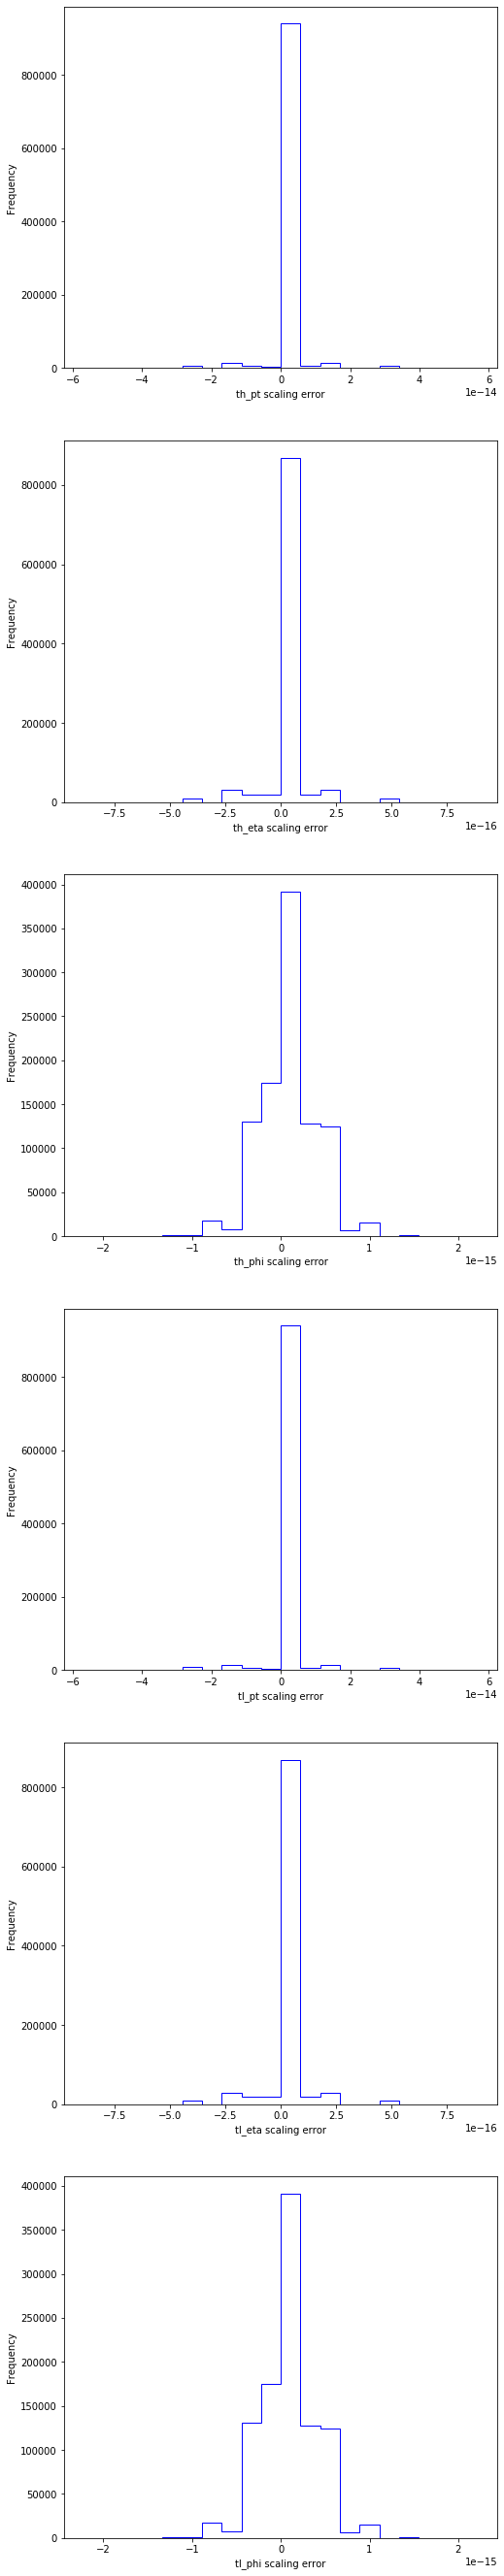

In [8]:
# Test inverse scaling

out_scaled = invscale_arrays(output_keys, total_output, maxmean)

plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    plt.hist(dataset.get(output_keys[i])[0:crop0] - out_scaled[:, i], 20, histtype='step', color='b')
    plt.xlabel(output_keys[i] + " scaling error")
    plt.ylabel('Frequency')

In [9]:
# Create input and test array
split = int(np.floor(0.8*crop0)) # 80/20 split 
shuffle = False

if shuffle:
    rng_state = np.random.get_state()
    np.random.shuffle(total_input)
    np.random.set_state(rng_state)
    np.random.shuffle(total_output)

train_input, test_input = total_input[0:split, :], total_input[split:,:]
train_output, test_output = total_output[0:split,:], total_output[split:,:]

In [10]:
print(train_input.shape, train_output.shape)
print(test_input.shape, test_output.shape)

(800000, 45) (800000, 6)
(200000, 45) (200000, 6)


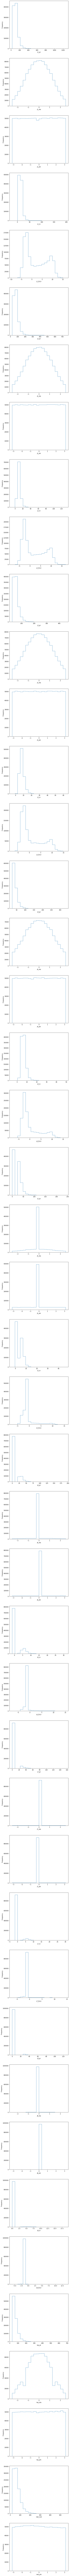

In [11]:
show = True

if show:
    plt.figure(figsize=(8,8*input_length))
    for i in range(0, input_length):
        plt.subplot(input_length, 1, i+1)
        plt.hist(np.array(dataset.get(input_keys[i]))[0:crop0], 20, histtype='step')
        plt.xlabel(input_keys[i])
        plt.ylabel('Frequency')

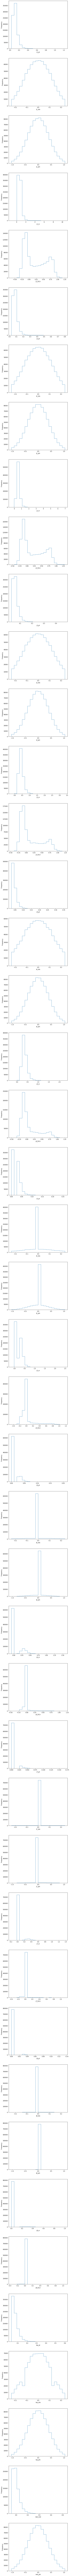

In [12]:
# Histograms of input variables 
show = True

if show:
    plt.figure(figsize=(8,8*input_length))
    for i in range(0, input_length):
        plt.subplot(input_length, 1, i+1)
        plt.hist(train_input[:,i], 20, histtype='step')
        plt.xlabel(input_keys[i])
        plt.ylabel('Frequency')

 

In [13]:
# Build model

# optimizer = keras.optimizers.RMSprop(learning_rate = 1e-5)
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


def build_model():
    model = keras.Sequential([
        layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.0001),
                     input_shape=[len(input_keys)]),
        layers.Dense(256,  activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dense(256,  activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)),
        layers.Dense(len(output_keys),  activation='linear')
    ])
    
    model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    return model 

# def build_model():
#     model = keras.Sequential([
#         layers.Dense(6, activation='linear', 
#                      input_shape=[len(input_keys)])])
    
#     model.compile(loss='mse', optimizer= optimizer, metrics=['mse'])
    
#     return model 
    

In [14]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               23552     
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_4 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_5 (Dense)              (None, 6)                 774       
Total params: 270,854
Trainable params: 270,854
Non-trainable params: 0
__________________________________________________

In [15]:
# Fit model

Epochs= 2048

history = model.fit(train_input, train_output, verbose=1, epochs=Epochs, 
                   validation_split=0.2, shuffle=False, callbacks=[callback],
                   batch_size=512)


Epoch 1/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1387 - mse: 0.0503 - val_loss: 0.1249 - val_mse: 0.0452
Epoch 2/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1162 - mse: 0.0438 - val_loss: 0.1085 - val_mse: 0.0427
Epoch 3/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.1023 - mse: 0.0419 - val_loss: 0.0967 - val_mse: 0.0414
Epoch 4/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0922 - mse: 0.0410 - val_loss: 0.0881 - val_mse: 0.0408
Epoch 5/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0846 - mse: 0.0404 - val_loss: 0.0815 - val_mse: 0.0403
Epoch 6/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0788 - mse: 0.0400 - val_loss: 0.0765 - val_mse: 0.0398
Epoch 7/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0744 - mse: 0.0396 - val_loss: 0.0726 - val_mse: 0.0395
Epoch 8/2048
1250/1250 [========================

Epoch 61/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0436 - mse: 0.0348 - val_loss: 0.0438 - val_mse: 0.0350
Epoch 62/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0435 - mse: 0.0348 - val_loss: 0.0437 - val_mse: 0.0350
Epoch 63/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0434 - mse: 0.0348 - val_loss: 0.0436 - val_mse: 0.0350
Epoch 64/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0433 - mse: 0.0347 - val_loss: 0.0435 - val_mse: 0.0350
Epoch 65/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0432 - mse: 0.0347 - val_loss: 0.0433 - val_mse: 0.0349
Epoch 66/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0431 - mse: 0.0347 - val_loss: 0.0432 - val_mse: 0.0349
Epoch 67/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0429 - mse: 0.0347 - val_loss: 0.0431 - val_mse: 0.0349
Epoch 68/2048
1250/1250 [================

1250/1250 [==============================] - 6s 5ms/step - loss: 0.0396 - mse: 0.0338 - val_loss: 0.0400 - val_mse: 0.0342
Epoch 121/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0396 - mse: 0.0338 - val_loss: 0.0400 - val_mse: 0.0342
Epoch 122/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0395 - mse: 0.0338 - val_loss: 0.0399 - val_mse: 0.0342
Epoch 123/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0395 - mse: 0.0338 - val_loss: 0.0399 - val_mse: 0.0342
Epoch 124/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0395 - mse: 0.0337 - val_loss: 0.0399 - val_mse: 0.0342
Epoch 125/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0394 - mse: 0.0337 - val_loss: 0.0399 - val_mse: 0.0342
Epoch 126/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0394 - mse: 0.0337 - val_loss: 0.0398 - val_mse: 0.0342
Epoch 127/2048
1250/1250 [=======================

1250/1250 [==============================] - 6s 5ms/step - loss: 0.0379 - mse: 0.0331 - val_loss: 0.0386 - val_mse: 0.0337
Epoch 180/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0379 - mse: 0.0330 - val_loss: 0.0386 - val_mse: 0.0337
Epoch 181/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0379 - mse: 0.0330 - val_loss: 0.0386 - val_mse: 0.0337
Epoch 182/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0379 - mse: 0.0330 - val_loss: 0.0385 - val_mse: 0.0337
Epoch 183/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0378 - mse: 0.0330 - val_loss: 0.0385 - val_mse: 0.0337
Epoch 184/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0378 - mse: 0.0330 - val_loss: 0.0385 - val_mse: 0.0337
Epoch 185/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0378 - mse: 0.0330 - val_loss: 0.0385 - val_mse: 0.0337
Epoch 186/2048
1250/1250 [=======================

1250/1250 [==============================] - 6s 5ms/step - loss: 0.0369 - mse: 0.0325 - val_loss: 0.0378 - val_mse: 0.0334
Epoch 239/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0369 - mse: 0.0325 - val_loss: 0.0378 - val_mse: 0.0334
Epoch 240/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0369 - mse: 0.0325 - val_loss: 0.0378 - val_mse: 0.0334
Epoch 241/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0369 - mse: 0.0325 - val_loss: 0.0378 - val_mse: 0.0334
Epoch 242/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0369 - mse: 0.0325 - val_loss: 0.0378 - val_mse: 0.0333
Epoch 243/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0369 - mse: 0.0325 - val_loss: 0.0377 - val_mse: 0.0333
Epoch 244/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0369 - mse: 0.0325 - val_loss: 0.0377 - val_mse: 0.0333
Epoch 245/2048
1250/1250 [=======================

1250/1250 [==============================] - 6s 5ms/step - loss: 0.0363 - mse: 0.0321 - val_loss: 0.0373 - val_mse: 0.0331
Epoch 298/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0363 - mse: 0.0321 - val_loss: 0.0373 - val_mse: 0.0331
Epoch 299/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0363 - mse: 0.0321 - val_loss: 0.0373 - val_mse: 0.0331
Epoch 300/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0363 - mse: 0.0321 - val_loss: 0.0373 - val_mse: 0.0331
Epoch 301/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0363 - mse: 0.0321 - val_loss: 0.0373 - val_mse: 0.0331
Epoch 302/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0363 - mse: 0.0321 - val_loss: 0.0372 - val_mse: 0.0331
Epoch 303/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0362 - mse: 0.0321 - val_loss: 0.0372 - val_mse: 0.0331
Epoch 304/2048
1250/1250 [=======================

1250/1250 [==============================] - 6s 5ms/step - loss: 0.0358 - mse: 0.0318 - val_loss: 0.0369 - val_mse: 0.0329
Epoch 357/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0358 - mse: 0.0318 - val_loss: 0.0369 - val_mse: 0.0329
Epoch 358/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0358 - mse: 0.0318 - val_loss: 0.0369 - val_mse: 0.0329
Epoch 359/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0358 - mse: 0.0318 - val_loss: 0.0369 - val_mse: 0.0329
Epoch 360/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0358 - mse: 0.0318 - val_loss: 0.0369 - val_mse: 0.0329
Epoch 361/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0358 - mse: 0.0318 - val_loss: 0.0369 - val_mse: 0.0329
Epoch 362/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0358 - mse: 0.0318 - val_loss: 0.0369 - val_mse: 0.0329
Epoch 363/2048
1250/1250 [=======================

1250/1250 [==============================] - 6s 5ms/step - loss: 0.0355 - mse: 0.0315 - val_loss: 0.0367 - val_mse: 0.0328
Epoch 416/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0355 - mse: 0.0315 - val_loss: 0.0367 - val_mse: 0.0328
Epoch 417/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0355 - mse: 0.0315 - val_loss: 0.0367 - val_mse: 0.0328
Epoch 418/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0354 - mse: 0.0315 - val_loss: 0.0367 - val_mse: 0.0328
Epoch 419/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0354 - mse: 0.0315 - val_loss: 0.0367 - val_mse: 0.0328
Epoch 420/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0354 - mse: 0.0315 - val_loss: 0.0367 - val_mse: 0.0328
Epoch 421/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0354 - mse: 0.0315 - val_loss: 0.0367 - val_mse: 0.0327
Epoch 422/2048
1250/1250 [=======================

1250/1250 [==============================] - 6s 5ms/step - loss: 0.0352 - mse: 0.0313 - val_loss: 0.0365 - val_mse: 0.0326
Epoch 475/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0352 - mse: 0.0313 - val_loss: 0.0365 - val_mse: 0.0326
Epoch 476/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0352 - mse: 0.0313 - val_loss: 0.0365 - val_mse: 0.0326
Epoch 477/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0351 - mse: 0.0313 - val_loss: 0.0365 - val_mse: 0.0326
Epoch 478/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0351 - mse: 0.0313 - val_loss: 0.0365 - val_mse: 0.0326
Epoch 479/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0351 - mse: 0.0313 - val_loss: 0.0365 - val_mse: 0.0326
Epoch 480/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0351 - mse: 0.0313 - val_loss: 0.0365 - val_mse: 0.0326
Epoch 481/2048
1250/1250 [=======================

1250/1250 [==============================] - 6s 5ms/step - loss: 0.0349 - mse: 0.0311 - val_loss: 0.0364 - val_mse: 0.0326
Epoch 534/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0349 - mse: 0.0311 - val_loss: 0.0364 - val_mse: 0.0326
Epoch 535/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0349 - mse: 0.0311 - val_loss: 0.0364 - val_mse: 0.0326
Epoch 536/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0349 - mse: 0.0311 - val_loss: 0.0364 - val_mse: 0.0326
Epoch 537/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0349 - mse: 0.0311 - val_loss: 0.0364 - val_mse: 0.0325
Epoch 538/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0349 - mse: 0.0311 - val_loss: 0.0364 - val_mse: 0.0325
Epoch 539/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0349 - mse: 0.0311 - val_loss: 0.0364 - val_mse: 0.0325
Epoch 540/2048
1250/1250 [=======================

1250/1250 [==============================] - 6s 5ms/step - loss: 0.0347 - mse: 0.0309 - val_loss: 0.0363 - val_mse: 0.0325
Epoch 593/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0347 - mse: 0.0309 - val_loss: 0.0363 - val_mse: 0.0325
Epoch 594/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0347 - mse: 0.0309 - val_loss: 0.0363 - val_mse: 0.0325
Epoch 595/2048
1250/1250 [==============================] - 6s 4ms/step - loss: 0.0347 - mse: 0.0309 - val_loss: 0.0363 - val_mse: 0.0325
Epoch 596/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0347 - mse: 0.0309 - val_loss: 0.0363 - val_mse: 0.0325
Epoch 597/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0347 - mse: 0.0309 - val_loss: 0.0363 - val_mse: 0.0325
Epoch 598/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0347 - mse: 0.0309 - val_loss: 0.0362 - val_mse: 0.0325
Epoch 599/2048
1250/1250 [=======================

1250/1250 [==============================] - 6s 5ms/step - loss: 0.0345 - mse: 0.0307 - val_loss: 0.0362 - val_mse: 0.0324
Epoch 652/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0345 - mse: 0.0307 - val_loss: 0.0362 - val_mse: 0.0324
Epoch 653/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0345 - mse: 0.0307 - val_loss: 0.0362 - val_mse: 0.0324
Epoch 654/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0345 - mse: 0.0307 - val_loss: 0.0362 - val_mse: 0.0324
Epoch 655/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0345 - mse: 0.0307 - val_loss: 0.0362 - val_mse: 0.0324
Epoch 656/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0344 - mse: 0.0307 - val_loss: 0.0362 - val_mse: 0.0324
Epoch 657/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0344 - mse: 0.0307 - val_loss: 0.0362 - val_mse: 0.0324
Epoch 658/2048
1250/1250 [=======================

1250/1250 [==============================] - 6s 5ms/step - loss: 0.0343 - mse: 0.0305 - val_loss: 0.0361 - val_mse: 0.0324
Epoch 711/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0343 - mse: 0.0305 - val_loss: 0.0361 - val_mse: 0.0324
Epoch 712/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0343 - mse: 0.0305 - val_loss: 0.0361 - val_mse: 0.0324
Epoch 713/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0343 - mse: 0.0305 - val_loss: 0.0361 - val_mse: 0.0324
Epoch 714/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0343 - mse: 0.0305 - val_loss: 0.0361 - val_mse: 0.0324
Epoch 715/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0343 - mse: 0.0305 - val_loss: 0.0361 - val_mse: 0.0324
Epoch 716/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0343 - mse: 0.0305 - val_loss: 0.0361 - val_mse: 0.0324
Epoch 717/2048
1250/1250 [=======================

1250/1250 [==============================] - 6s 5ms/step - loss: 0.0341 - mse: 0.0304 - val_loss: 0.0361 - val_mse: 0.0323
Epoch 770/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0341 - mse: 0.0304 - val_loss: 0.0361 - val_mse: 0.0323
Epoch 771/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0341 - mse: 0.0303 - val_loss: 0.0361 - val_mse: 0.0323
Epoch 772/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0341 - mse: 0.0303 - val_loss: 0.0361 - val_mse: 0.0323
Epoch 773/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0341 - mse: 0.0303 - val_loss: 0.0361 - val_mse: 0.0323
Epoch 774/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0341 - mse: 0.0303 - val_loss: 0.0361 - val_mse: 0.0323
Epoch 775/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0341 - mse: 0.0303 - val_loss: 0.0361 - val_mse: 0.0323
Epoch 776/2048
1250/1250 [=======================

1250/1250 [==============================] - 6s 5ms/step - loss: 0.0340 - mse: 0.0302 - val_loss: 0.0360 - val_mse: 0.0323
Epoch 829/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0340 - mse: 0.0302 - val_loss: 0.0360 - val_mse: 0.0323
Epoch 830/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0339 - mse: 0.0302 - val_loss: 0.0360 - val_mse: 0.0323
Epoch 831/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0339 - mse: 0.0302 - val_loss: 0.0360 - val_mse: 0.0323
Epoch 832/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0339 - mse: 0.0302 - val_loss: 0.0360 - val_mse: 0.0323
Epoch 833/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0339 - mse: 0.0302 - val_loss: 0.0360 - val_mse: 0.0323
Epoch 834/2048
1250/1250 [==============================] - 6s 5ms/step - loss: 0.0339 - mse: 0.0302 - val_loss: 0.0360 - val_mse: 0.0323
Epoch 835/2048
1250/1250 [=======================

In [16]:
history.history.keys()
model.save(model_name)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: SameScale.h5py/assets


Text(0.5, 1.0, 'MSE loss')

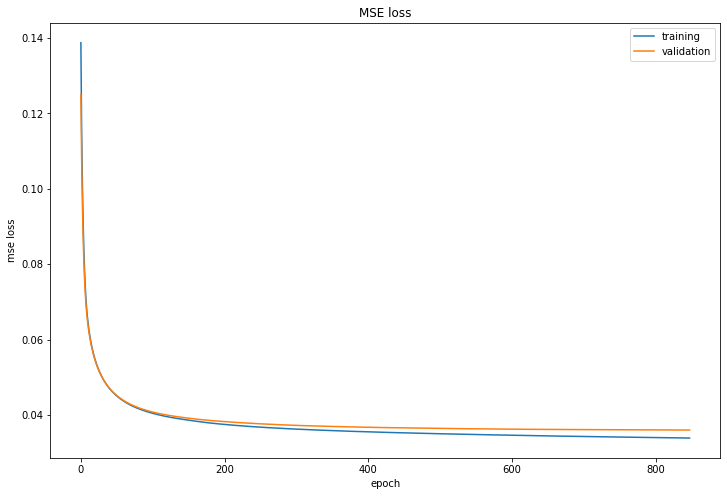

In [17]:
plt.figure(figsize=(12,8))
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epoch')
plt.ylabel('mse loss')
plt.legend()
plt.title('MSE loss')

In [18]:
predictions = model.predict(test_input)

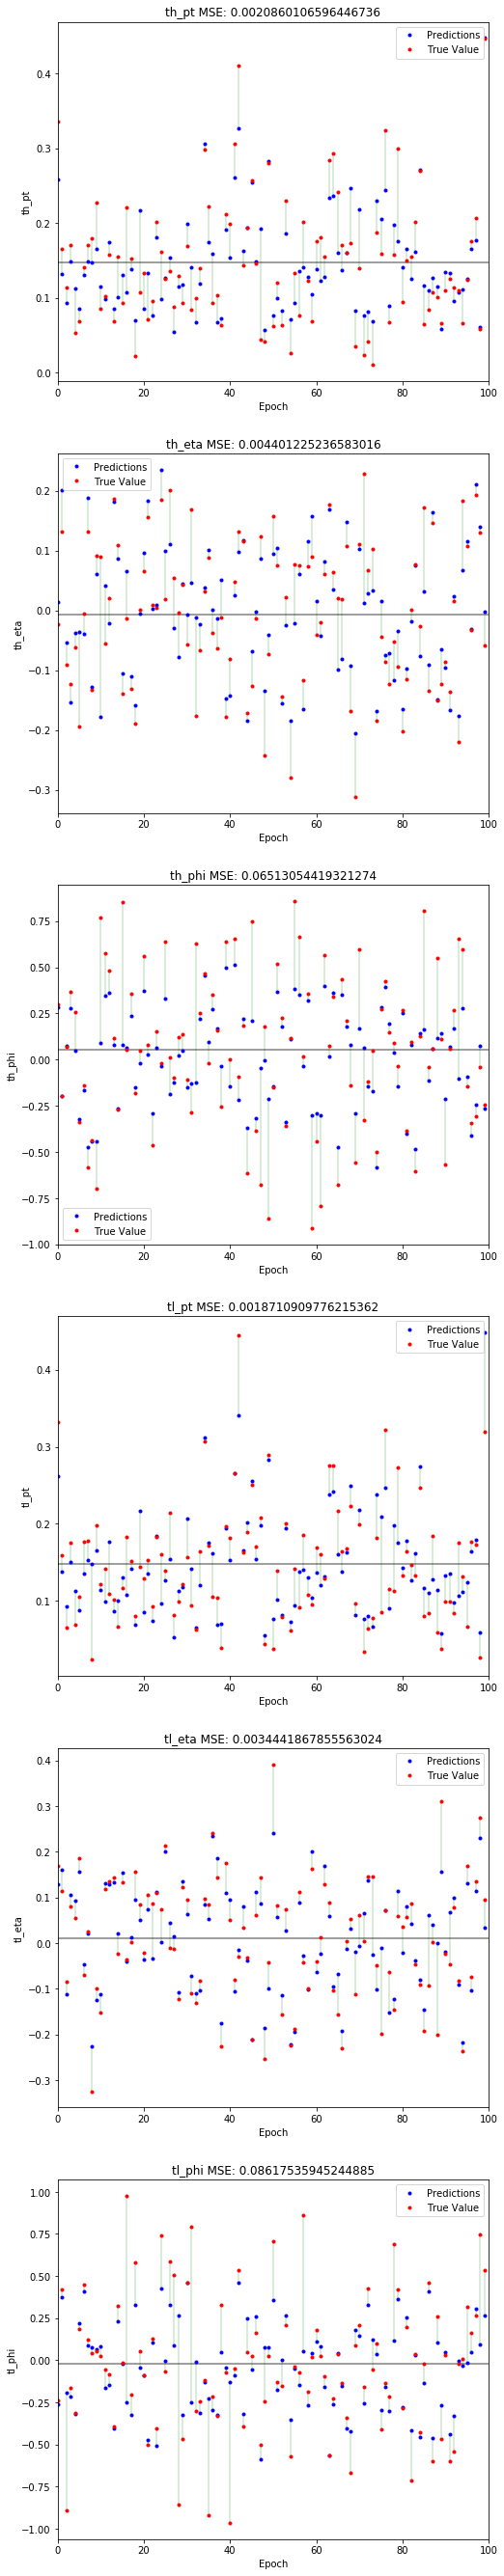

In [19]:
￼
# Training 
crop = 100 

train_small = model.predict(train_input[0:100,:])
output_small = train_output[0:100,:]

def comparison_plot(compare, true):
    plt.figure(figsize=(8,8*output_length))
    for i in range(0,output_length):
        plt.subplot(output_length,1,i+1)
        plt.plot(range(0,crop), compare[:,i], 'bo', markersize=3, label = 'Predictions')
        plt.plot(range(0,crop), true[:,i], 'ro', markersize=3, label = 'True Value')
        ym, yM = plt.ylim()
        for x in range(100):
            plt.vlines(x, color='g', linestyle='-', alpha=0.2, ymin= 
                        min(compare[x,i], true[x,i]), 
                        ymax= max(compare[x,i], true[x,i]))
        plt.hlines(np.mean(true[:,i]), xmin=-20, xmax=crop+20, alpha=0.5)
        MSE = 1/compare[:,i].size*np.sum((compare[:,i]- true[:,i])**2)
        plt.xlabel('Epoch')
        plt.ylabel(output_keys[i])
        plt.xlim(0, crop)
        plt.title(output_keys[i] + " MSE: " + str(MSE))
        plt.legend()

comparison_plot(train_small, output_small)

In [20]:
# Predictions

predictions_small = predictions[0:100,:]
test_output_small = test_output[0:100,:]

MSE = 1/predictions.size*np.sum((predictions- test_output)**2)
print("total MSE: " + str(MSE))

for i in range(output_length):
    MSE = 1/predictions[:,i].size*np.sum((predictions[:,i] -test_output[:,i])**2)
    print("{0} MSE : ".format(output_keys[i]), '%.10f'%MSE)

total MSE: 0.032072152548500904
th_pt MSE :  0.0022805107
th_eta MSE :  0.0059838291
th_phi MSE :  0.0950793181
tl_pt MSE :  0.0019629255
tl_eta MSE :  0.0044230640
tl_phi MSE :  0.0827032680


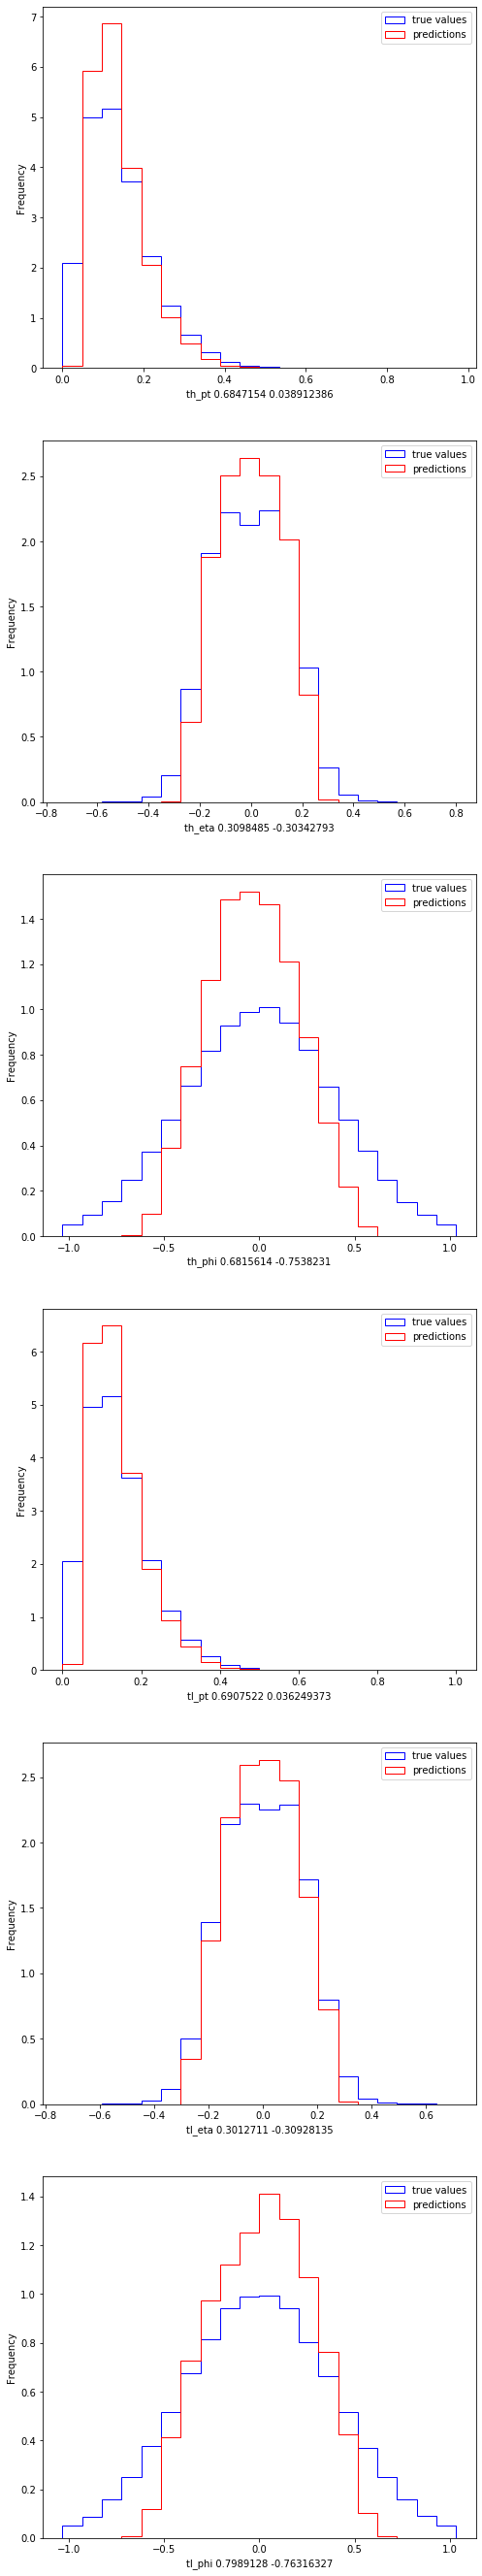

In [21]:
# Unscaled Histograms 

plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    hist0, bin_edges = np.histogram(test_output[:, i], bins=20)
    plt.hist(test_output[:,i], bin_edges, histtype='step', color='b', label='true values', density=True)
    plt.hist(predictions[:,i], bin_edges, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(output_keys[i] +" " +str(np.max(predictions[:,i])) + " " + str(np.min(predictions[:,i])))
    plt.legend()
    plt.ylabel('Frequency')

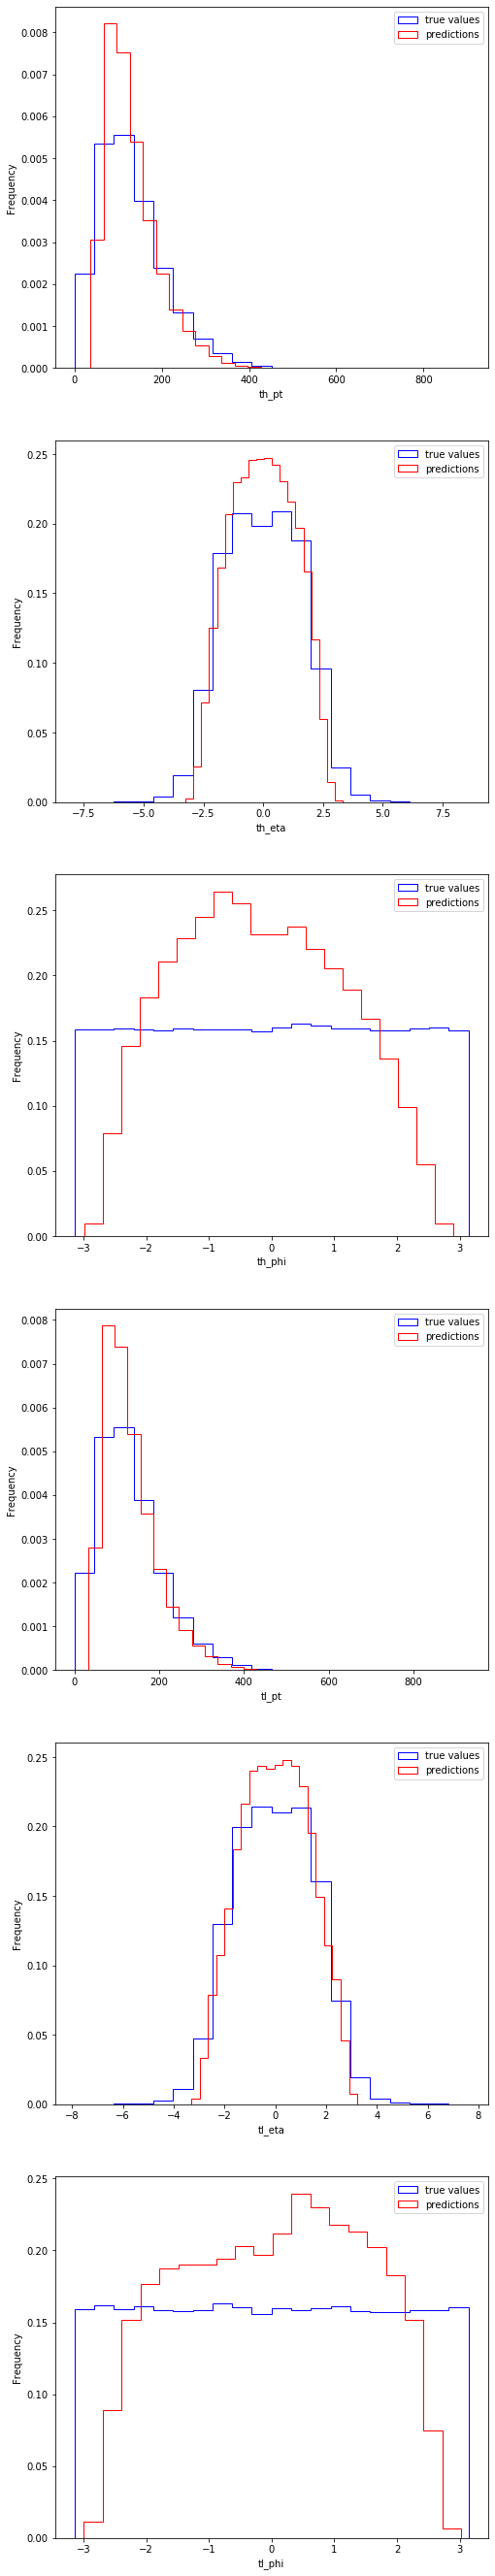

In [22]:
# Histograms to the original scale 

total_predictions = model.predict(total_input) 
# out_scaled = invscale_arrays(output_keys, out_max0, out_mean, total_output)
out_scaled = invscale_arrays(output_keys, total_output, maxmean)[split:,:]
# predict_scaled = invscale_arrays(output_keys, out_max0, out_mean, total_predictions)[split:,:]
predict_scaled = invscale_arrays(output_keys, total_predictions, maxmean)[split:,:]

plt.figure(figsize=(8,8*output_length))
for i in range(len(output_keys)):
    plt.subplot(output_length, 1, i+1)
    # hist0, bin_edges = np.histogram(out_scaled[:, i], bins=20)
    plt.hist(out_scaled[:, i], 20, histtype='step', color='b', label='true values', density=True)
    plt.hist(predict_scaled[:, i], 20, histtype='step', color='r', label='predictions', density=True)
    plt.xlabel(output_keys[i])
    plt.legend()
    plt.ylabel('Frequency')

In [23]:
for i in range(output_length):
    MSE = 1/predict_scaled[:,i].size*np.sum((predict_scaled[:,i] -out_scaled[:,i])**2)
    print("Original Scale {0} MSE : ".format(output_keys[i]), '%.10f'%MSE)

Original Scale th_pt MSE :  1974.1414433198
Original Scale th_eta MSE :  0.6867939613
Original Scale th_phi MSE :  1.9103829013
Original Scale tl_pt MSE :  1699.2213567210
Original Scale tl_eta MSE :  0.5076571493
Original Scale tl_phi MSE :  1.5676454363
